## Import Packages

In [1]:
#importing some useful packages
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.preprocessing import StandardScaler
import glob
%matplotlib inline

In [2]:
# Define a function to compute binned color features
def bin_spatial(img, size=(32, 32)):
  # Use cv2.resize().ravel() to create the feature vector
  features = cv2.resize(img, size).ravel()
  # Return the feature vector
  return features

In [3]:
# Color classify
# Define a function to compute color histogram features
def color_hist(img, nbins=32, bins_range=(0, 256)):
  # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:, :, 0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:, :, 1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:, :, 2], bins=nbins, range=bins_range)
  # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
  # Return the individual histograms, bin_centers and feature vector
    return hist_features

### Extract HOG feature

In [4]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                    spatial_size=(32,32), hist_bins=32, 
                    spatial_feature=False, hist_feature=False, hog_feature=False):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        cur_feature = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      
        
        if spatial_feature == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            cur_feature.append(spatial_features)
        if hist_feature == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            cur_feature.append(hist_features)
        if hog_feature == True:
            # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            cur_feature.append(hog_features)
        features.append(np.concatenate(cur_feature))
    # Return list of feature vectors
    return features




In [5]:
# extract features from one image
def extract_features_from_one_img(img, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                    spatial_size=(32,32), hist_bins=32, 
                    spatial_feature=True, hist_feature=True, hog_feature=True):
    # Create a list to append feature vectors to
    cur_feature = []
   
    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)      

    if spatial_feature == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        cur_feature.append(spatial_features)
    if hist_feature == True:
        # Apply color_hist()
        hist_features = color_hist(feature_image, nbins=hist_bins)
        cur_feature.append(hist_features)
    if hog_feature == True:
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            #hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        cur_feature.append(hog_features)

    return np.concatenate(cur_feature)





### Load data

8792 8968


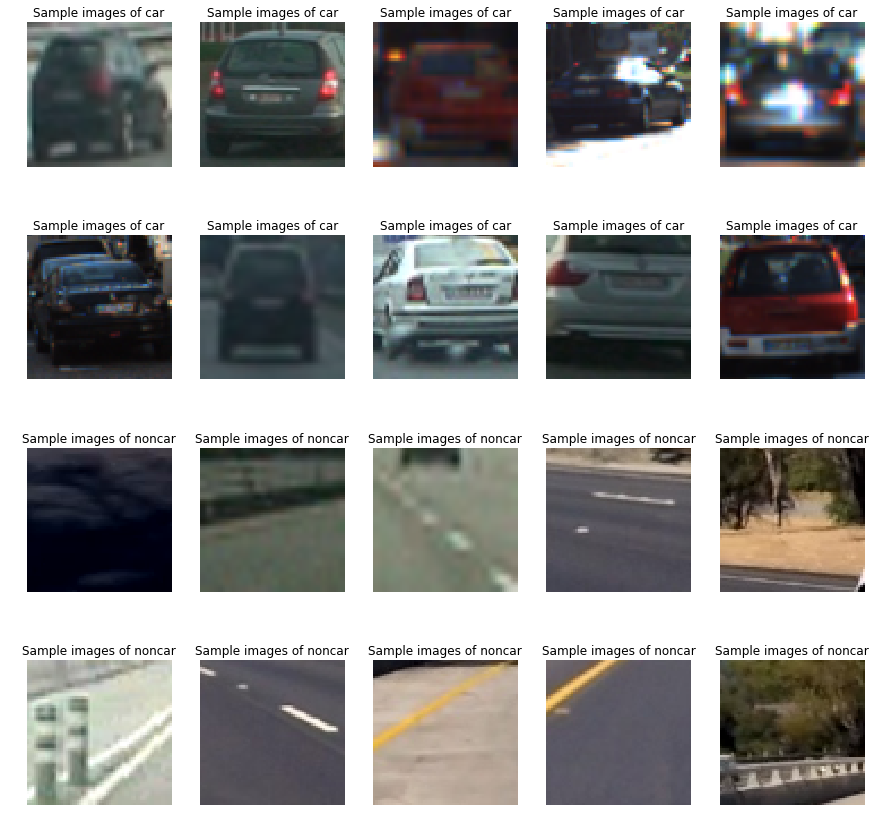

In [6]:
# Load data

cars = glob.glob('vehicles/*/*')
noncars = glob.glob('non-vehicles/*/*')
print(len(cars), len(noncars))

f, axs = plt.subplots(4, 5, figsize=(15, 15))
axs = axs.ravel()

for i in range(10):
    img = cv2.imread(cars[np.random.randint(0, len(cars))])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('Sample images of car', fontsize=12)
    axs[i].imshow(img)

for i in range(10,20):
    img = cv2.imread(noncars[np.random.randint(0, len(noncars))])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('Sample images of noncar', fontsize=12)
    axs[i].imshow(img)
    
plt.savefig('./output_images/dataset_visual.jpg')

/Users/hji/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


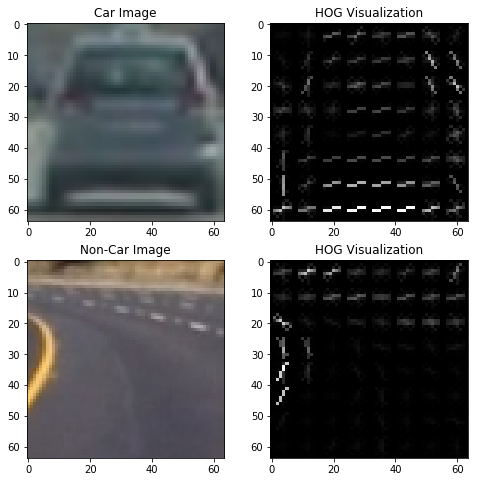

In [7]:
# Visualize HOG features on example image
car_im = mpimg.imread(cars[3])
car_gray = cv2.cvtColor(car_im, cv2.COLOR_RGB2GRAY)
noncar_im = mpimg.imread(noncars[3])
noncar_gray = cv2.cvtColor(noncar_im, cv2.COLOR_RGB2GRAY)
orient = 9
pix_per_cell = 8
cell_per_block = 2

fea3, hog_img3 = get_hog_features(car_gray, orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True)
non_fea3, non_hog_img3 = get_hog_features(noncar_gray, orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True)

fig,((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize=(8,8))
ax1.imshow(car_im, cmap='gray')
ax1.set_title('Car Image')
ax2.imshow(hog_img3, cmap='gray')
ax2.set_title('HOG Visualization')
ax3.imshow(noncar_im, cmap='gray')
ax3.set_title('Non-Car Image')
ax4.imshow(non_hog_img3, cmap='gray')
ax4.set_title('HOG Visualization')
plt.savefig('./output_images/hog_example.jpg')

### Training classifier

In [200]:
# Parameter tuning

cspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32)
hist_bins = 32
spatial_feature = True
hist_feature = True
hog_feature = True
t = time.time()

car_features = extract_features(cars, cspace, orient, 
                        pix_per_cell, cell_per_block, hog_channel,
                    spatial_size, hist_bins, 
                    spatial_feature, hist_feature, hog_feature)

noncar_features = extract_features(noncars, cspace, orient, 
                        pix_per_cell, cell_per_block, hog_channel,
                    spatial_size, hist_bins, 
                    spatial_feature, hist_feature, hog_feature)

t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, noncar_features)).astype(np.float64)  

# Up-sample non-car data to reduce false positive
#X = np.vstack((car_features, noncar_features, noncar_features, noncar_features)).astype(np.float64)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(noncar_features))))#3*len(noncar_features)

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.1, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

115.43 Seconds to extract features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
39.14 Seconds to train SVC...
Test Accuracy of SVC =  0.9899
My SVC predicts:  [ 0.  1.  0.  0.  0.  0.  1.  1.  1.  0.]
For these 10 labels:  [ 0.  1.  0.  0.  0.  1.  1.  1.  1.  0.]
0.01006 Seconds to predict 10 labels with SVC


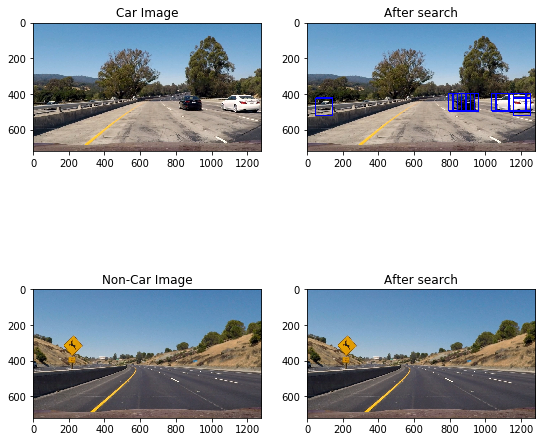

In [232]:

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2

# dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )
# svc = dist_pickle["svc"]
# X_scaler = dist_pickle["scaler"]
# orient = dist_pickle["orient"]
# pix_per_cell = dist_pickle["pix_per_cell"]
# cell_per_block = dist_pickle["cell_per_block"]
# spatial_size = dist_pickle["spatial_size"]
# hist_bins = dist_pickle["hist_bins"]

def convert_color(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)


# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, hog_channel):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    # an array of rectangles that cars were detected
    boxes = []
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    if hog_channel == "ALL":
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    else:
        hog = get_hog_features(ctrans_tosearch[:,:,hog_channel], orient, pix_per_cell, cell_per_block, feature_vec=False)


    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            if hog_channel == "ALL":
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    return boxes, draw_img
    
ystart = 400
ystop = 656
scale = 1.5

img = mpimg.imread('test_images/test1.jpg')
_, out_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, "ALL")

noncar_img = plt.imread('test_images/test2.jpg')
_, out_img_noncar = find_cars(noncar_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, "ALL")

fig,((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize=(9,9))
ax1.imshow(img, cmap='gray')
ax1.set_title('Car Image')
ax2.imshow(out_img, cmap='gray')
ax2.set_title('After search')
ax3.imshow(noncar_img, cmap='gray')
ax3.set_title('Non-Car Image')
ax4.imshow(out_img_noncar, cmap='gray')
ax4.set_title('After search')
plt.savefig('./output_images/find_car_example.jpg')

In [233]:
def draw_boxes(img, bounding_boxes, color=(0,0,255),thick=6):
    imcopy = np.copy(img)
    for bb in bounding_boxes:
        cv2.rectangle(imcopy, bb[0], bb[1], color, thick)
    return imcopy

In [234]:
# pass an image and a list of boxes/windows to be searched 
def search_windows(img, boxes, clf, scaler, cspace='YCrCb', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel="ALL",
                    spatial_size=(32,32), hist_bins=32, 
                    spatial_feature=True, hist_feature=True, hog_feature=True):
    # An array for positive window
    positive_windows = []
    for window in windows:
        cur_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]],(64,64))
        # extract features
        cur_features = extract_features_from_one_img(cur_img, cspace, orient, 
                            pix_per_cell, cell_per_block, hog_channel,
                        spatial_size, hist_bins, 
                        spatial_feature, hist_feature, hog_feature)
        test_features = scaler.transform(np.array(cur_features).reshape(1,-1))
        # Predicting
        predict_res = clf.predict(test_features)
        if prediction == 1:
            positive_windows.append(window)
    return positive_windows


18 boxes found


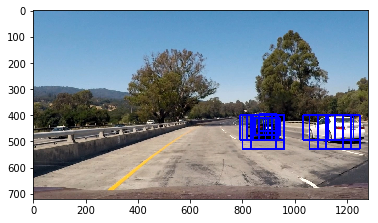

In [247]:
# Test the combinations of values of ystart, ystop, and scale
# Search the image by multiple scales

cspace = 'YCrCb'
spatial_size = (32,32)
hist_bins= 32
orient=9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'

test_img = mpimg.imread('./test_images/test1.jpg')
hot_boxes = []
  #scale 0:
#     ystart = 400
#     ystop = 656
#     scale = 1.5
#     box, output_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
#                            cell_per_block, spatial_size, hist_bins, hog_channel)
#     hot_boxes.append(box)
    #scale 1:
ystart = 380
ystop = 500
scale = 1.0
box, output_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                       cell_per_block, spatial_size, hist_bins, hog_channel)
hot_boxes.append(box)

ystart = 400
ystop = 520
scale = 1.5
box, output_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                       cell_per_block, spatial_size, hist_bins, hog_channel)
hot_boxes.append(box)

ystart = 400
ystop = 600
scale = 2.0
box, output_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                       cell_per_block, spatial_size, hist_bins, hog_channel)
hot_boxes.append(box)

ystart = 400
ystop = 600
scale = 3.5
box, output_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                       cell_per_block, spatial_size, hist_bins, hog_channel)
hot_boxes.append(box)


flat_list = []
for box in hot_boxes:
    for sub in box:
        flat_list.append(sub)
test_res = draw_boxes(test_img, flat_list, color=(0,0,255), thick=6)

print(len(flat_list), "boxes found")
plt.imshow(test_res)
plt.savefig('./output_images/test_window.jpg')
# imgs = []
# images = glob.glob('test_images/*.jpg')

# for im in images:
#     test_img = mpimg.imread(im) #'./test_images/test1.jpg'
#     _, output_img = find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
#                            cell_per_block, spatial_size, hist_bins, hog_channel)
#     imgs.append(output_img)

# plt.figure(figsize=(18,10))
# for i in range(len(imgs)):
#     plt.subplot(2,3,i+1)
#     plt.axis('off')
#     plt.imshow(imgs[i])
# plt.savefig('./output_images/tuning_windows_setting0.jpg')



In [237]:
# test
def single_img_features(img, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)
    #9) Return concatenated array of features
    return np.concatenate(img_features)

def search_windows(img, windows, clf, scaler, cspace='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=8, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, cspace, 
                            spatial_size, hist_bins, 
                            orient, pix_per_cell, 
                            cell_per_block, 
                            hog_channel, spatial_feat, 
                            hist_feat, hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        test_features = scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    


        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

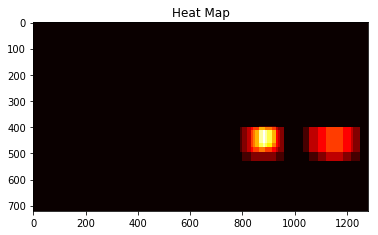

In [244]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from scipy.ndimage.measurements import label

# Read in a pickle file with bboxes saved
# Each item in the "all_bboxes" list will contain a 
# list of boxes for one of the images shown above
# box_list = pickle.load( open( "bbox_pickle.p", "rb" ))

#image = mpimg.imread('test_image.jpg')
# heat = np.zeros_like(image[:,:,0]).astype(np.float)

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
    
img = mpimg.imread('test_images/test1.jpg')
#img = mpimg.imread('test_images/test1.jpg')
#boxes, out_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, "ALL")


heat = np.zeros_like(img[:,:,0]).astype(np.float)
# Add heat to each box in box list
heat = add_heat(heat,flat_list)


# # Apply threshold to help remove false positives
# heat = apply_threshold(heat,2)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map') 

plt.savefig('./output_images/heatmap0.jpg')

# # Find final boxes from heatmap using label function
# labels = label(heatmap)
# draw_img = draw_labeled_bboxes(np.copy(image), labels)

# fig = plt.figure()
# plt.subplot(121)
# plt.imshow(draw_img)
# plt.title('Car Positions')
# plt.subplot(122)
# plt.imshow(heatmap, cmap='hot')
# plt.title('Heat Map')
# fig.tight_layout()


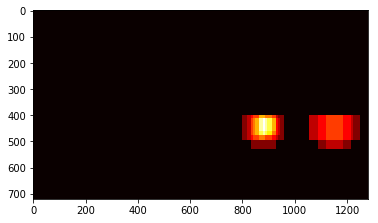

In [245]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image and all boxes
    return img

heatmap_img = apply_threshold(heatmap, 1)

plt.imshow(heatmap_img, cmap='hot')
plt.savefig('./output_images/threshold_heatmap.jpg')

2 cars found in this image


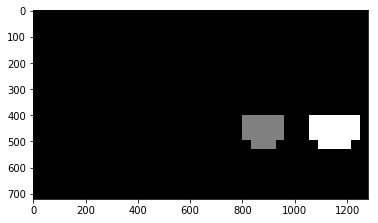

In [246]:
# Find final boxes from heatmap using label function
labels = label(heatmap)

fig = plt.figure()
#plt.figure(figsize=(10,10))
print(labels[1], 'cars found in this image')
plt.imshow(labels[0], cmap='gray')
plt.savefig('./output_images/draw_heatmap.jpg')

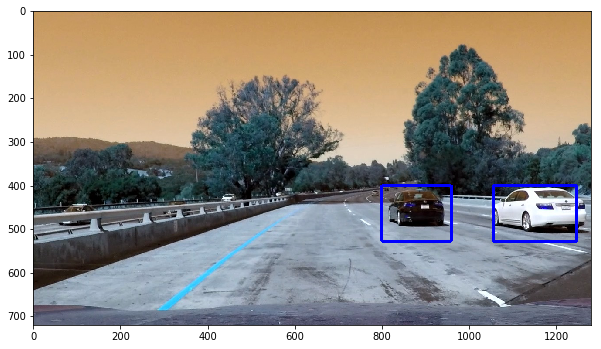

In [241]:
# draw box
draw_img = draw_labeled_bboxes(np.copy(image), labels)
plt.figure(figsize=(10,10))
plt.imshow(draw_img)

### Pipeline

In [242]:
def process_frame(img):
    cspace = 'YCrCb'
    spatial_size = (32,32)
    hist_bins= 32
    orient=9
    pix_per_cell = 8
    cell_per_block = 2
    hog_channel = 'ALL'
    
    hot_boxes = []

    #scale 1:
    ystart = 380
    ystop = 500
    scale = 1.0
    box, output_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                           cell_per_block, spatial_size, hist_bins, hog_channel)
    hot_boxes.append(box)
    
    ystart = 400
    ystop = 520
    scale = 1.5
    box, output_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                           cell_per_block, spatial_size, hist_bins, hog_channel)
    hot_boxes.append(box)
    
    ystart = 400
    ystop = 600
    scale = 2.0
    box, output_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                           cell_per_block, spatial_size, hist_bins, hog_channel)
    hot_boxes.append(box)
    
    ystart = 400
    ystop = 600
    scale = 3.5
    box, output_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                           cell_per_block, spatial_size, hist_bins, hog_channel)
    hot_boxes.append(box)
    
    flat_list = []
    for box in hot_boxes:
        for sub in box:
            flat_list.append(sub)
    
   
    heatmap_img = np.zeros_like(img[:,:,0]).astype(np.float)
    heatmap_img = add_heat(heatmap_img, flat_list)
    heatmap_img = apply_threshold(heatmap_img, 1)
    labels = label(heatmap_img)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img
    #return heatmap_img

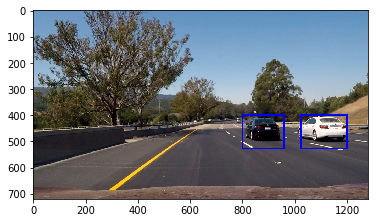

In [243]:
test_img = mpimg.imread('test_images/test6.jpg')


draw_img = process_frame(test_img)
plt.imshow(draw_img)


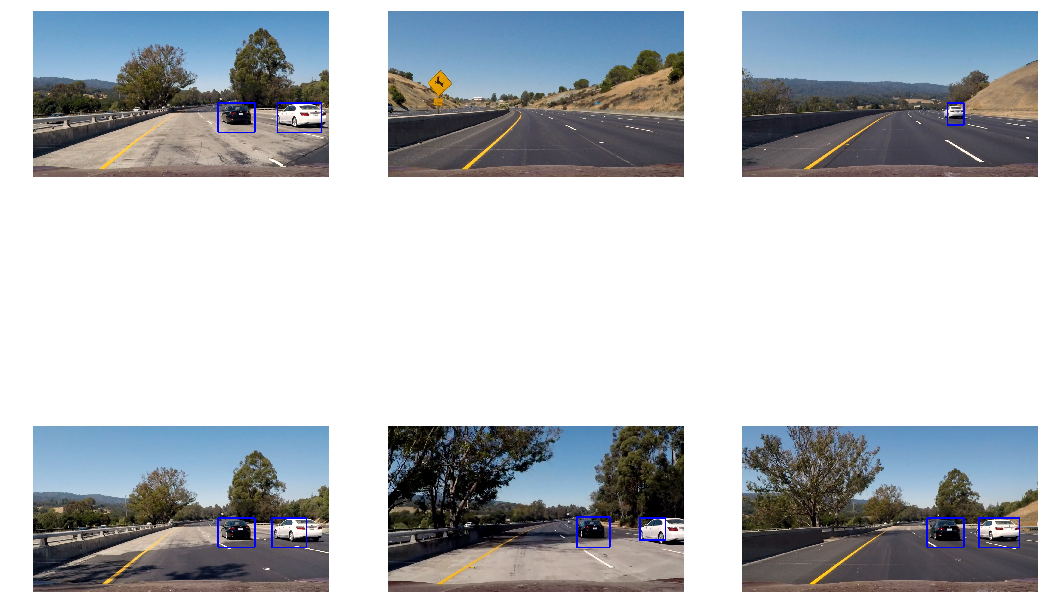

In [224]:
# Test all test_imgs
test_imgs = glob.glob('./test_images/test*.jpg')
fig, axs = plt.subplots(2, 3, figsize=(18,14))
axs = axs.ravel()
for i, img in enumerate(test_imgs):
    #axs[i].imshow(mpimg.imread(img))
    axs[i].imshow(process_frame(mpimg.imread(img)))
    axs[i].axis('off')
plt.savefig('./output_images/vehicle_detection.jpg')

In [210]:
# Save previous frames result to smooth the drawing

class Detection():
    def __init__(self, n):
        # number of frames to be used to smooth
        self.n =n 
        self.windows = []
        
    def add_smooth_detect(self, window):
        self.windows.append(window)
        if len(self.windows) > self.n:
            self.windows.pop(0)
        return self.windows
    
    def get_smooth_detect(self):
        return self.windows

In [225]:
def process_video(img,detection):
    
    cspace = 'YCrCb'
    spatial_size = (32,32)
    hist_bins= 32
    orient=9
    pix_per_cell = 8
    cell_per_block = 2
    hog_channel = 'ALL'
    
    hot_boxes = []
    #scale 0:
#     ystart = 400
#     ystop = 464#656
#     scale = 1.0#1.5
#     box, output_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
#                            cell_per_block, spatial_size, hist_bins, hog_channel)
#     hot_boxes.append(box)
    #scale 1:
    ystart = 380
    ystop = 500
    scale = 1.0
    box, output_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                           cell_per_block, spatial_size, hist_bins, hog_channel)
    hot_boxes.append(box)
    
    ystart = 400
    ystop = 520
    scale = 1.5
    box, output_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                           cell_per_block, spatial_size, hist_bins, hog_channel)
    hot_boxes.append(box)
    
    ystart = 400
    ystop = 600
    scale = 2.0
    box, output_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                           cell_per_block, spatial_size, hist_bins, hog_channel)
    hot_boxes.append(box)
    
    ystart = 400
    ystop = 600
    scale = 3.5
    box, output_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                           cell_per_block, spatial_size, hist_bins, hog_channel)
    hot_boxes.append(box)
    
    flat_list = []
    for box in hot_boxes:
        for sub in box:
            flat_list.append(sub)
    heatmap_img = np.zeros_like(img[:,:,0]).astype(np.float)
    if len(flat_list) > 0:
        detection.add_smooth_detect(flat_list)
    
    cur_windows = detection.get_smooth_detect()
    for window in cur_windows:
        heatmap_img = add_heat(heatmap_img, flat_list)
#     
#     heatmap_img = add_heat(heatmap_img, flat_list)
    heatmap_img = apply_threshold(heatmap_img, 1+len(cur_windows)//2)
    labels = label(heatmap_img)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img
   

In [226]:
# Import everything needed to edit/save/watch video clips
# import imageio
# imageio.plugins.ffmpeg.download()

from moviepy.editor import VideoFileClip
from IPython.display import HTML

frames = 10
detection = Detection(frames)

def vehicle_detect(img):
    return process_video(img, detection)

In [227]:
#imageio.plugins.ffmpeg.download() 
test_output = 'project_video_output2.mp4'#'project_output_video.mp4'#'test_video_out.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip('project_input_p4.mp4')#.subclip(23,30)
clip1 = VideoFileClip('project_video.mp4')#.subclip(15,30)

clip_out = clip1.fl_image(vehicle_detect) #NOTE: this function expects color images!!
%time clip_out.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video project_video_output2.mp4
[MoviePy] Writing video project_video_output2.mp4


100%|█████████▉| 1260/1261 [12:52<00:00,  1.80it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output2.mp4 

CPU times: user 12min, sys: 44.4 s, total: 12min 44s
Wall time: 12min 54s
